In [1]:
import subprocess as sp
import os
import silence_tensorflow.auto # pylint: disable=unused-import
import tensorflow as tf

def mask_unused_gpus(leave_unmasked=1):

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"

  try:
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    available_gpus = [i for i, x in enumerate(memory_free_values) if x > ACCEPTABLE_AVAILABLE_MEMORY]

    if len(available_gpus) < leave_unmasked: raise ValueError('Found only %d usable GPUs in the system' % len(available_gpus))
    gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
    tf.config.experimental.set_visible_devices(gpus[available_gpus[0]], 'GPU')
  
  except Exception as e:
    print('"nvidia-smi" is probably not installed. GPUs are not masked', e)

mask_unused_gpus()

In [12]:
import absl.logging
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
absl.logging.set_verbosity(absl.logging.ERROR)

In [3]:
os.chdir('/home/ricky/RNNAE')

data_GP = np.array(np.load('data_GP.npy', allow_pickle=True))
data_meta_GP = np.array(np.load('data_meta_GP.npy', allow_pickle=True))

In [4]:
def create_input(rep=16, split_portion=0.8, num_of_type=1):

  claimedtype = []

  input = [ [] for i in range(num_of_type+1)]
  input_train = [ [] for i in range(num_of_type+1)]
  input_test = [ [] for i in range(num_of_type+1)]
  type_train = [ [] for i in range(num_of_type+1)]
  type_test = [ [] for i in range(num_of_type+1)]

  for i in range(len(data_meta_GP)):

    if 'Ia' in data_meta_GP[i][-2]:
          claimedtype.append(0)
    if 'IIP' in data_meta_GP[i][-2]:
          claimedtype.append(1)

  for i in range(len(claimedtype)):

      input[0].append(list(data_GP[i]))

      if claimedtype[i] == 0:
          input[1].append(list(data_GP[i]))
      if claimedtype[i] == 1:
          input[2].append(list(data_GP[i]))

  for i in range(len(input)):
      
      input[i] = np.array(input[i])

      input_train[i] = input[i][:int(split_portion*len(input[i]))]
      input_test[i]  = input[i][int(split_portion*len(input[i])):]

      input[i]       = K.cast_to_floatx(input[i].transpose((0, 2, 1)))
      input_train[i] = K.cast_to_floatx(input_train[i].transpose((0, 2, 1)))
      input_test[i]  = K.cast_to_floatx(input_test[i].transpose((0, 2, 1)))

      input[i]       = np.repeat(input[i][:,:,1:-3], rep, axis=1)
      input_train[i] = np.repeat(input_train[i][:,:,1:-3], rep, axis=1)
      input_test[i]  = np.repeat(input_test[i][:,:,1:-3], rep, axis=1)

      input[i]       = np.reshape(input[i],(input[i].shape[0], int(input[i].shape[1]/rep), int(input[i].shape[2]*rep), 1))
      input_train[i] = np.reshape(input_train[i],(input_train[i].shape[0], int(input_train[i].shape[1]/rep), int(input_train[i].shape[2]*rep), 1))
      input_test[i]  = np.reshape(input_test[i],(input_test[i].shape[0], int(input_test[i].shape[1]/rep), int(input_test[i].shape[2]*rep), 1))

      type_train[i]  = claimedtype[:int(split_portion*len(input[i]))]
      type_test[i]   = claimedtype[int(split_portion*len(input[i])):]

  for i in range(len(input)-1):
      print(f'For type {claimedtype[i]}, total size of data is {input[i].shape}, training size is {input_train[i].shape}, testing size is {input_test[i].shape}')

  return input, input_train, input_test, type_train, type_test

In [5]:
input, input_train, input_test, type_train, type_test = create_input()

For type 0, total size of data is (1144, 200, 48, 1), training size is (915, 200, 48, 1), testing size is (229, 200, 48, 1)


In [6]:
print(input_train[0][0][100])

[[-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]
 [-0.02119758]
 [-0.04742501]
 [-0.01031577]]


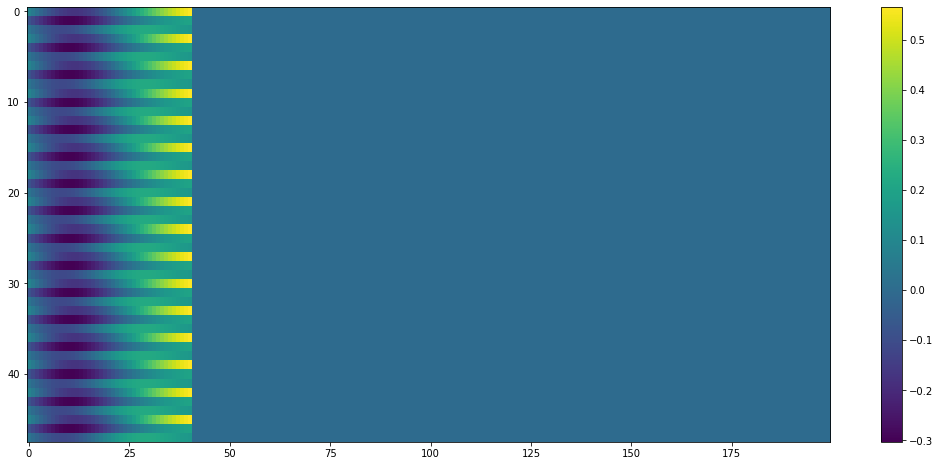

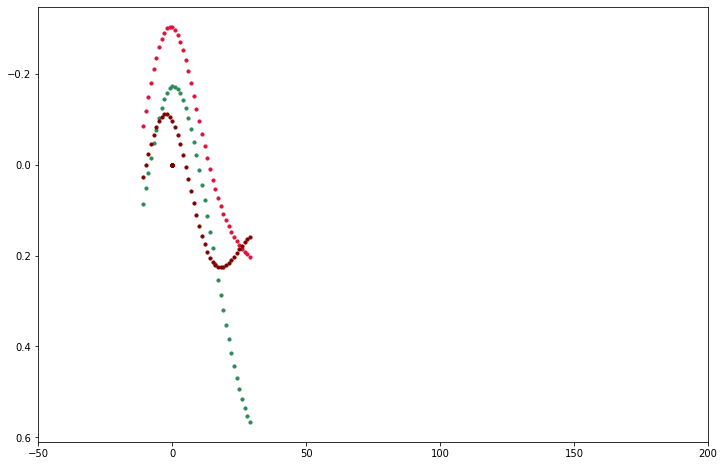

In [7]:
i = 2
fig = plt.figure(figsize=(18, 8))
pos = plt.imshow(input_train[0][i].reshape(200, 48).T, aspect='auto')
fig.colorbar(pos)

fig = plt.figure(figsize=(12,8))
color1 = ['seagreen', 'crimson', 'maroon']
plt.gca().invert_yaxis()
plt.xlim(-50, 200)
for j in range(3):
    plt.scatter(data_GP[i,0,:], data_GP[i,j+1,:], s=10, marker='o', color=color1[j])

In [10]:
def cnnae(input):

  input_seq = keras.Input(shape=(input[0].shape[1], input[0].shape[2], 1))

  x = Conv2D(64, (3, 3), activation="relu", padding="same")(input_seq)
  x = MaxPooling2D((2, 2), padding="same")(x)
  x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
  encoded = MaxPooling2D((2, 2), padding="same")(x)

  # Decoder
  x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(encoded)
  x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
  decoded = Conv2D(1, (3, 3), activation="tanh", padding="same")(x)

  autoencoder = keras.Model(input_seq, decoded)
  encoder = keras.Model(input_seq, encoded)

  opt = Adam(learning_rate=0.0001)

  autoencoder.compile(optimizer=opt, loss="mse")
  print(autoencoder.summary())

  return autoencoder, encoder

def cnnae_train(autoencoder, input_tmp, patience=10, epochs=100):

  callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience,
                       verbose=0, mode='min', baseline=None,
                       restore_best_weights=True)

  history = autoencoder.fit(
                          x=input_tmp,
                          y=input_tmp,
                          validation_split = 0.1,
                          epochs=epochs,
                          verbose=1,
                          callbacks=[callbacks])

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.ylim(0, 1e-4)

  os.chdir('/home/ricky/RNNAE')
  plt.savefig('CNN training history.pdf')

  return

In [13]:
def import_data(x):

    x = np.load(f'{x}.npy', allow_pickle=True)
    x = np.asarray(x).astype('float32')

    return x

def cnnae_test(autoencoder, input_tmp):

    yhat = autoencoder.predict(x=input_tmp, verbose=1)
    yhat_loss = autoencoder.evaluate(x=input_tmp, y=input_tmp, verbose=1)

    return yhat

def latent_space_demo(encoder, input_tmp):

    latent_space = encoder.predict(input_tmp, verbose=1)

    os.chdir('/home/ricky/RNNAE/CNN_latent_space_graph')

    '''for i in range(latent_space.shape[1] - 1):
        for j in range(latent_space.shape[1] - 1 - i):
            fig = plt.figure(figsize=(6, 6))
            plt.grid()
            plt.scatter(latent_space[:,i], latent_space[:,i+j+1], s=8)
            plt.title(f'id {i} vs id {i+j+1}.pdf')
            plt.savefig(f'id_{i}_vs_id_{i+j+1}.pdf')
            plt.close()'''

    return latent_space

def isolation_forest(latent_space, n_tree, split):

    clf = IsolationForest(n_estimators=n_tree, warm_start=True)
    clf.fit(latent_space)
    anomaly = clf.score_samples(latent_space)
    anomaly_id = np.argsort(anomaly)

    shutil.rmtree('/home/ricky/RNNAE/CNN_anomaly_graph')
    os.makedirs('/home/ricky/RNNAE/CNN_anomaly_graph')

    for i, ano in enumerate(anomaly_id):
        shutil.copy(f'/home/ricky/RNNAE/GP_graph/{data_meta_GP[ano+split][-1]}.pdf', f'/home/ricky/RNNAE/CNN_anomaly_graph/{i}_{data_meta_GP[ano+split][-1]}.pdf')

    return

def reconstruction_graph(input_tmp, yhat, split, filters=['g', 'r', 'i']):

    color1 = ['seagreen', 'crimson', 'maroon']
    color2 = ['darkgreen', 'firebrick', 'darkred']

    shutil.rmtree('/home/ricky/RNNAE/CNN_reconstruction_graph')
    os.makedirs('/home/ricky/RNNAE/CNN_reconstruction_graph')

    for i in tqdm(range(input_tmp.shape[0])):

        os.chdir('/home/ricky/RNNAE/CNN_reconstruction_graph')

        isExist = os.path.exists(f'./{data_meta_GP[i+split][-1]}')

        if not isExist:
            os.makedirs(f'./{data_meta_GP[i+split][-1]}')
            os.chdir(f'./{data_meta_GP[i+split][-1]}')

        fig, axs = plt.subplots(3, figsize=(12, 18))

        fig.suptitle('Images of CNN')
        axs[0].set_title('input test image')
        axs[1].set_title('reconstructed test image')
        axs[2].set_title('difference')

        a1 = axs[0].imshow(input_tmp[i].reshape(200,48).T, interpolation='nearest', aspect='auto')
        a2 = axs[1].imshow(yhat[i].reshape(200,48).T, interpolation='nearest', aspect='auto')
        a3 = axs[2].imshow((input_tmp[i] - yhat[i]).reshape(200,48).T, interpolation='nearest', aspect='auto')

        fig.savefig(f'./{data_meta_GP[i][-1]}.pdf', bbox_inches='tight')

        plt.close()

        for j, filter in enumerate(filters):
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(1, 1, 1)

            plt.gca().invert_yaxis()

            # And a corresponding grid
            ax.grid(which='major', alpha=0.8)
            ax.grid(which='minor', alpha=0.3)

            plt.xlabel('Timestep', fontsize=15)
            plt.ylabel('Absolute Magnitude', fontsize=15)

            plt.xlim(-50, 200)

            plt.title(f'{data_meta_GP[i+split][-1]}, {data_meta_GP[i+split][-2]}, {filter}')

            #plt.errorbar(data_GP[i+split][0], data_GP[i+split][j+1], y_err=data_GP[i+split][j+4], fmt='v')

            plt.scatter(data_GP[i+split,0,:], input_tmp[i][:,j,:data_meta_GP[i+split][0]], s=2, marker='o', color=color1[j], label=f'test data'.format('o'))
            plt.scatter(data_GP[i+split,0,:], yhat[i][:,j,:data_meta_GP[i+split][0]], s=12, marker='X', color=color2[j], label=f'reconstruction'.format('X'))
            
            plt.legend()

            plt.savefig(f'./{data_meta_GP[i][-1]}_{filter}_band.pdf')

            plt.close()

    return

def cnn_predict(autoencoder, encoder, input_tmp, **kwargs):

    split = int(0.8*(data_GP.shape[0]))

    if kwargs['training_data']:
        split = 0

    yhat = cnnae_test(autoencoder, input_tmp)
    #print('Plotting reconstruction graphs...')
    #reconstruction_graph(input_tmp, yhat, split)

    return

In [14]:
input, input_train, input_test, type_train, type_test = create_input()

os.chdir('/home/ricky/RNNAE/CNN_npy')
np.save('input.npy', np.array(input, dtype=object))
np.save('input_train.npy', np.array(input_train, dtype=object))
np.save('input_test.npy', np.array(input_test, dtype=object))
np.save('type_train.npy', np.array(type_train, dtype=object))
np.save('type_test.npy', np.array(type_test, dtype=object))

autoencoder, encoder = cnnae(input)
cnnae_train(autoencoder, input_train[0])

autoencoder.save('/home/ricky/RNNAE/CNN_autoencoder_model')
encoder.save('/home/ricky/RNNAE/CNN_encoder_model')

cnn_predict(autoencoder, encoder, input_test[0], training_data=False)

latent_space = latent_space_demo(encoder, input_train[0])
isolation_forest(latent_space, 1000, 0)

print('end of CNN_model.py')

predictions = autoencoder.predict(input_test[0])
print(predictions.shape)

For type 0, total size of data is (1144, 200, 48, 1), training size is (915, 200, 48, 1), testing size is (229, 200, 48, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 48, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 48, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 24, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 24, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 12, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 100, 24, 64)       36928     
___

KeyboardInterrupt: 

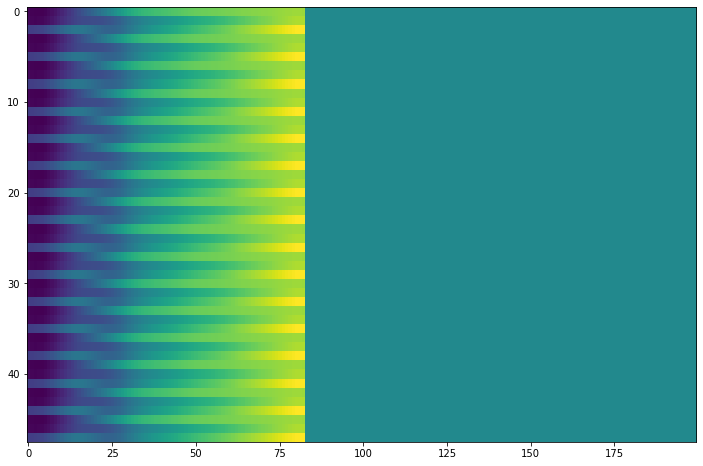

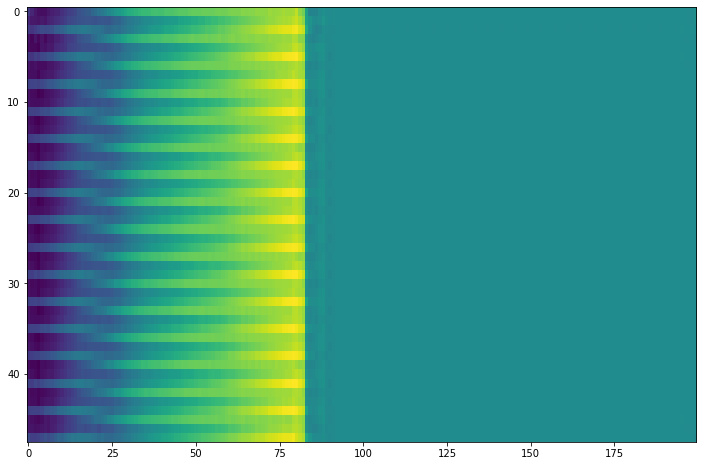

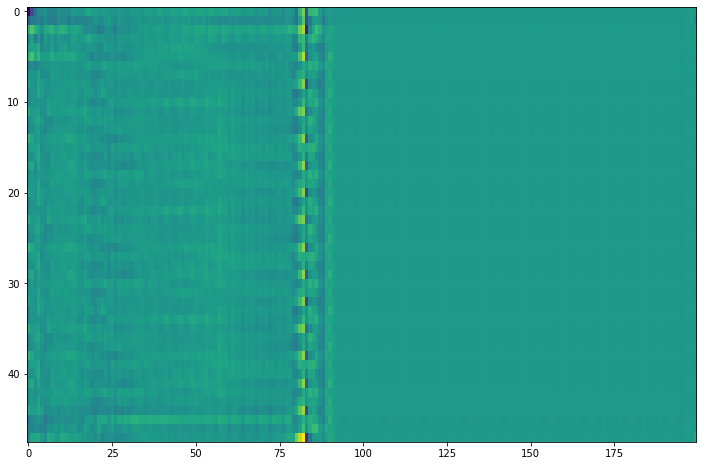

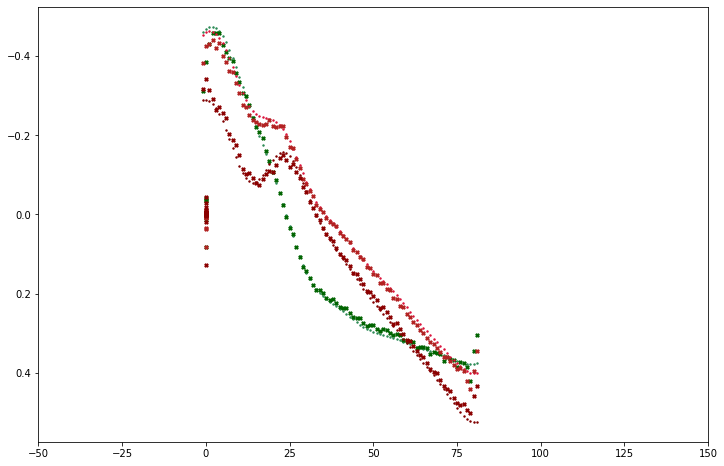

In [10]:
i=11

fig = plt.figure(figsize=(12, 8))
plt.imshow(input_test[0][i].reshape(200,48).T, interpolation='nearest', aspect='auto')
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.imshow(predictions[i].reshape(200,48).T, interpolation='nearest', aspect='auto')
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.imshow((input_test[0][i] - predictions[i]).reshape(200,48).T, interpolation='nearest', aspect='auto')
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.gca().invert_yaxis()
plt.xlim(-50, 150)
split = int(0.8*(data_GP.shape[0]))
color1 = ['seagreen', 'crimson', 'maroon']
color2 = ['darkgreen', 'firebrick', 'darkred']
for j in range(3):
    plt.scatter(data_GP[i+split,0,:], input_test[0][i][:,j,:data_meta_GP[i+split][0]], s=2, marker='o', color=color1[j])
    plt.scatter(data_GP[i+split,0,:], predictions[i][:,j,:data_meta_GP[i+split][0]], s=12, marker='X', color=color2[j])

In [11]:
latent_space = encoder.predict(input_test[0], verbose=1)
print(latent_space.shape)

8/8 [==============================] - 0s 7ms/step
(229, 50, 12, 64)
